# About
* This notebook contains a quick prototyp to load entire Nutrition5k data, both dish and dish_ingredients are available  
* Callback Creator with default params
* Sample size of 50
* Shows how to upload the directory to tensorboard dev

# Utility & Model Building Components

In [1]:
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable


## CallbackHelper

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import datetime


class CallbackHelper:
    def __init__(self, base_dir, logs_dir="/logs"):
        self.base_dir = base_dir

        self.logs_base_dir = base_dir + logs_dir

        self.timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    def create_callback(self, callback_name=None, experiment=None,  tb_write_images=True, tb_hist_freq=1,
                        es_monitor="val_loss", es_patience=10, lrs_schedule=None, lrs_verbose=0):
        callback = None

        if callback_name == 'MC':
            log_file = self.get_log_file(callback_name, experiment)
            callback = tf.keras.callbacks.ModelCheckpoint(log_file)
            print("Log file used = ", log_file)

        if callback_name == 'TB':
            log_file = self.get_log_file(callback_name, experiment)
            callback = tf.keras.callbacks.TensorBoard(log_dir=log_file,
                                                      write_images=tb_write_images,
                                                      histogram_freq=tb_hist_freq)
            print("Log file used = ", log_file)
            
        if callback_name == 'ES':
            callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor,
                                                        patience=es_patience)
        if callback_name == 'TQDM':
            callback = tfa.callbacks.TQDMProgressBar()

        if callback_name == 'LRS':
            callback = tf.keras.callbacks.LearningRateScheduler(lrs_schedule, lrs_verbose=lrs_verbose)


        return callback

    def get_log_file(self, callback_name, experiment):
        log_path = self.logs_base_dir + experiment + "/" + self.timestamp + "/" + callback_name
        return log_path


## ImageProcessor

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


class ImagePreProcessor:
    def __init__(self, dishes):
        self.dishes = dishes

    @staticmethod
    def crop(img):
        # argwhere will give you the coordinates of every non-zero point
        true_points = np.argwhere(img)
        # take the smallest points and use them as the top left of your crop
        top_left = true_points.min(axis=0)
        # take the largest points and use them as the bottom right of your crop
        bottom_right = true_points.max(axis=0)
        out = img[top_left[0]:bottom_right[0] + 1,  # plus 1 because slice isn't
              top_left[1]:bottom_right[1] + 1]  # inclusive
        return out

    @staticmethod
    def rectangular_mask(dish_path):
        image_bgr = cv2.imread(dish_path)
        mask = np.zeros(image_bgr.shape[:2], dtype="uint8")
        # mask = cv2.rectangle(mask, (0, 480), (180, 580), 255, -1)
        mask = cv2.rectangle(mask, (180, 30), (600, 480), 255, -1)
        masked = cv2.bitwise_or(image_bgr, image_bgr, mask=mask)
        masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
        return image_bgr, mask, masked

    @staticmethod
    def remove_blue(hsv_image):
        input_image = hsv_image.copy()

        grayscale_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

        # Convert the BGR image to HSV:
        hsv_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

        # Create the HSV range for the blue ink:
        # [128, 255, 255], [90, 50, 70]
        lower_values = np.array([90, 50, 70])
        upper_values = np.array([128, 255, 255])

        # Get binary mask of the blue ink:
        blue_mask = cv2.inRange(hsv_image, lower_values, upper_values)
        # Use a little bit of morphology to clean the mask:
        # Set kernel (structuring element) size:
        kernel_size = 3
        # Set morph operation iterations:
        op_iterations = 1
        # Get the structuring element:
        morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        # Perform closing:
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, morph_kernel, None, None, op_iterations,
                                     cv2.BORDER_REFLECT101)

        # Add the white mask to the grayscale image:
        color_mask = cv2.add(grayscale_image, blue_mask)
        _, binary_image = cv2.threshold(color_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # cv2.imwrite('bwimage.jpg',binary_image)
        thresh, im_bw = cv2.threshold(binary_image, 210, 230, cv2.THRESH_BINARY)
        kernel = np.ones((1, 1), np.uint8)
        image_final = cv2.dilate(im_bw, kernel=kernel, iterations=1)
        return image_final

    @staticmethod
    def get_final_img(self, image_path, crop_only=False):
        orig_bgr, mask, masked = self.rectangular_mask(image_path)
        cropped_out = self.crop(masked)
        out = []
        if crop_only:
            out.append([orig_bgr, mask, masked, cropped_out, None])
        else:
            rgb = cropped_out.copy()
            hsv = cv2.cvtColor(cropped_out, cv2.COLOR_BGR2HSV)
            imgfinal = self.remove_blue(hsv)
            copy_of = imgfinal.copy()
            # copy_of[copy_of > 0] = 255
            final_img = cv2.bitwise_and(rgb, rgb, mask=copy_of)
            out.append([orig_bgr, mask, masked, cropped_out, final_img])
        return out

    @staticmethod
    def test(self, n=2, crop_only=False):
        index = random.sample(list(np.arange(len(self.dishes))), n)
        img_paths = [self.dishes[i] for i in index]
        out = []
        for i, path in enumerate(img_paths):
            orig_bgr, mask, masked = self.rectangular_mask(path)
            cropped_out = self.crop(masked)
            if crop_only:
                out.append([orig_bgr, mask, masked, cropped_out, None])
            else:
                rgb = cropped_out.copy()
                hsv = cv2.cvtColor(cropped_out, cv2.COLOR_BGR2HSV)
                imgfinal = self.remove_blue(hsv)
                copy_of = imgfinal.copy()
                # copy_of[copy_of > 0] = 255
                final_img = cv2.bitwise_and(rgb, rgb, mask=copy_of)
                out.append([orig_bgr, mask, masked, cropped_out, final_img])
        return out

    @staticmethod
    def display_sample(self, sample, crop_only=False):
        grid = 1
        n = len(sample)
        c = 4 if crop_only else 5
        plt.figure(figsize=(15, 10))
        for i, lst in enumerate(sample):
            img = cv2.cvtColor(lst[0], cv2.COLOR_BGR2RGB)
            plt.subplot(n, c, grid)
            plt.imshow(img)
            plt.title("original")

            grid += 1
            plt.subplot(n, c, grid)
            plt.imshow(lst[1])
            plt.title("mask")

            grid += 1
            plt.subplot(n, c, grid)
            plt.imshow(lst[2])
            plt.title("masked-out")

            grid += 1
            plt.subplot(n, c, grid)
            plt.imshow(lst[3])
            plt.title("cropped")

            if not crop_only:
                grid += 1
                plt.subplot(n, c, grid)
                plt.imshow(lst[4])
                plt.title("final-out")
            grid += 1


## VITConfig

In [4]:
class VITConfig:
    def __init__(self,
                 image_size=None,
                 patch_size=None,
                 projection_dim=None,
                 num_heads=None,
                 transformer_layers=None,
                 mlp_head_units=None,
                 output_shape=None):
        self.image_size = image_size
        self.patch_size = patch_size
        self.input_shape = (image_size, image_size, 3)  # input image shape
        self.num_patches = (image_size // patch_size) ** 2
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        # Size of the transformer layers
        self.transformer_units = [
            projection_dim * 2,
            projection_dim,
        ]
        self.transformer_layers = transformer_layers
        self.mlp_head_units = mlp_head_units  # Size of the dense layers
        self.output_size = output_shape

    def data_augmentation_layers(self, inputs):
        pass


## DatasetUtil

In [60]:
import pandas as pd
import os
import matplotlib.pyplot as plt


class DatasetUtil:
    @staticmethod
    def get_top_30_ingredients(dish_ingredients):
        dish_ing_by_count = dish_ingredients[['dish_id', 'name', 'id']] \
            .groupby('dish_id', as_index=False).id.count() \
            .sort_values(by="id", ascending=False)
        return dish_ing_by_count

    @staticmethod
    def check_dir(dish_ids, image_dir):
        # print("Dish Shape",dish_ids.shape)
        df = pd.DataFrame(columns=['dish_id', 'exists'])
        for dish_id in dish_ids:
            # print(dish_images +  id)
            df.loc[len(df.index)] = [dish_id, os.path.exists(image_dir + dish_id)]
        return df

    @staticmethod
    def get_image_path(dish_ids,
                       image_dir,
                       file_name="/rgb.png"):
        print("Dish Shape",dish_ids.shape)
        print("Image path",image_dir)
        images = []
        for dish_id in dish_ids:
            if os.path.exists(image_dir + dish_id):
                images.append({"dish_id": dish_id, "image_path": image_dir + dish_id + file_name})
        df = pd.DataFrame(images, columns=["dish_id", "image_path"])
        return df

    @staticmethod
    def get_rgb_image(dish_ids,
                      image_dir,
                      file_name="/rgb.png"):
        # print("Dish Shape",dish_ids)
        images = []
        for dish_id in dish_ids:
            # print("Types = ",type(dish_images_path),type(dish_id))
            if os.path.exists(image_dir + dish_id):
                images.append({"dish_id": dish_id, "image": plt.imread(image_dir + dish_id + file_name)})
        return images


## DatasetConfig

In [47]:
class DatasetConfig:
    def __init__(self,
                 base_dir=None,
                 image_dir='',
                 metadata_dir='',
                 splits_dir='',
                img_file_name='/rgb.png'):
        self.workspace = base_dir
        self.image_dir = self.workspace + image_dir
        self.metadata_dir = self.workspace + metadata_dir
        self.splits_dir = self.workspace + splits_dir
        self.depth_train_file = "/depth_train_ids.txt"
        self.depth_test_file = "/depth_test_ids.txt"
        self.rgb_train_file = "/rgb_train_ids.txt"
        self.rgb_test_file = "/rgb_test_ids.txt"
        self.dish_cafe1_file = "/dish_metadata_cafe1.csv"
        self.dish_cafe2_file = "/dish_metadata_cafe2.csv"
        self.dish_ingredients_file = '/ingredients_metadata.csv'
        self.dish_id_col = ["dish_id"]
        self.image_file_name = img_file_name


## DataLoader

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import random

class DataLoader:
    def __init__(self, data_config: DatasetConfig,
                 debug: bool = False,subset=False):
        self.rgb_train = None
        self.rgb_test = None
        self.depth_test = None
        self.depth_train = None
        self.test_dish_ids = None
        self.train_dish_ids = None
        self.data_config = data_config
        self.cafe1_dish_info = DishInfo(data_config.metadata_dir + data_config.dish_cafe1_file)
        self.cafe2_dish_info = DishInfo(data_config.metadata_dir + data_config.dish_cafe2_file)
        self.dish_subset = None
        self.dish_ing_subset = None
        self.subset = subset
        cafe_1, cafe1_ing = self.cafe1_dish_info.get_dish_info()
        cafe_2, cafe2_ing = self.cafe2_dish_info.get_dish_info()
        self.LOG_HANDLE = "DataLoader -->"
        if debug:  # Display Information on the loaded files
            print(self.LOG_HANDLE, "Cafe = 1", "*" * 50)
            print(self.LOG_HANDLE, cafe_1.info())
            print(self.LOG_HANDLE, cafe_1.shape)
            print(self.LOG_HANDLE, "Cafe = 1 Dish Ingredients", "*" * 50)
            print(self.LOG_HANDLE, cafe1_ing.info())
            print(self.LOG_HANDLE, cafe1_ing.shape)

            print(self.LOG_HANDLE, "Cafe = 2", "*" * 50)
            print(self.LOG_HANDLE, cafe_2.info())
            print(self.LOG_HANDLE, "Shape = ", cafe_2.shape)
            print(self.LOG_HANDLE, "Cafe = 2 Dish Ingredients", "*" * 50)
            print(self.LOG_HANDLE, cafe2_ing.info())
            print(self.LOG_HANDLE, "Shape = ", cafe2_ing.shape)

        self.dish = pd.concat([cafe_1, cafe_2])
        self.dish_ingredients = pd.concat([cafe1_ing, cafe2_ing])
        print(self.LOG_HANDLE, "Total Dishes", self.dish.shape)
        print(self.LOG_HANDLE, "Total Dish Ingredients", self.dish_ingredients.shape)

        self.__cast_astype_float()

        self.__split_data(debug)

        self.__filter_data_with_images(debug)

    def get_dishes(self, subset=True):
        if subset:
            return self.dish_subset
        return self.dish

    def get_dish_ingredients(self, subset=True):
        if subset:
            return self.dish_ing_subset

        return self.dish_ingredients

    def get_data(self, subset=True):
        if subset:
            return self.dish_subset, self.dish_ing_subset

        return self.dish, self.dish_ingredients

    def get_splits(self):
        return self.train_dish_ids, self.test_dish_ids

    def __split_data(self, debug=False):
        self.depth_train = pd.read_csv(self.data_config.splits_dir + self.data_config.depth_train_file,
                                       header=None,
                                       names=self.data_config.dish_id_col)

        self.depth_test = pd.read_csv(self.data_config.splits_dir + self.data_config.depth_test_file,
                                      header=None,
                                      names=self.data_config.dish_id_col)

        self.rgb_test = pd.read_csv(self.data_config.splits_dir + self.data_config.rgb_test_file,
                                    header=None,
                                    names=self.data_config.dish_id_col)
        self.rgb_train = pd.read_csv(self.data_config.splits_dir + self.data_config.rgb_train_file,
                                     header=None,
                                     names=self.data_config.dish_id_col)
        if debug:
            print(self.LOG_HANDLE, "Depth train split ids shape = ", self.depth_train.shape)
            print(self.LOG_HANDLE, self.depth_train.head())
            print(self.LOG_HANDLE, "RGB train split ids shape = ", self.rgb_train.shape)
            print(self.LOG_HANDLE, self.rgb_train.head())
            print(self.LOG_HANDLE, "Depth test split ids shape = ", self.depth_test.shape)
            print(self.LOG_HANDLE, self.depth_test.head())
            print(self.LOG_HANDLE, "RGB test split ids shape = ", self.rgb_test.shape)
            print(self.LOG_HANDLE, self.rgb_test.head())

        self.train_dish_ids = pd.merge(self.depth_train, self.rgb_train)
        self.test_dish_ids = pd.merge(self.depth_test, self.rgb_test)
        if debug:
            print(self.LOG_HANDLE, "Train Dish Ids = ", self.train_dish_ids.shape)
            print(self.LOG_HANDLE, "Test Dish Ids = ", self.test_dish_ids.shape)

    def __verify_images(self, debug):
        s1 = DatasetUtil.check_dir(self.test_dish_ids.dish_id, self.data_config.image_dir)
        s2 = DatasetUtil.check_dir(self.train_dish_ids.dish_id, self.data_config.image_dir)
        s3 = DatasetUtil.check_dir(self.rgb_train.dish_id, self.data_config.image_dir)
        s4 = DatasetUtil.check_dir(self.rgb_test.dish_id, self.data_config.image_dir)

        if debug:
            print(self.LOG_HANDLE, "Test Dish Ids = ", self.test_dish_ids.shape, s1.shape,
                  s1.exists.value_counts())
            print(self.LOG_HANDLE, "Train Dish Ids = ", self.train_dish_ids.shape, s2.shape,
                  s2.exists.value_counts())
            print(self.LOG_HANDLE, "RGB Train Ids = ", self.rgb_train.shape, s3.shape,
                  s3.exists.value_counts())
            print(self.LOG_HANDLE, "RGB Test Ids = ", self.rgb_test.shape, s4.shape,
                  s4.exists.value_counts())

            i = random.randrange(0, len(self.train_dish_ids))
            # print(self.LOG_HANDLE,i,train_dish_ids.dish_id[i])
            img_path = self.data_config.image_dir + self.train_dish_ids.dish_id[i]
            # print(self.LOG_HANDLE,img_path)
            f, a = plt.subplots(1, 3)

            a[0].imshow(plt.imread(img_path + '/depth_color.png'))
            a[1].imshow(plt.imread(img_path + '/depth_raw.png'))
            a[2].imshow(plt.imread(img_path + '/rgb.png'))

            plt.show()

            i_test = random.randrange(0, len(self.test_dish_ids))
            # print(self.LOG_HANDLE,i,train_dish_ids.dish_id[i])
            img_path = self.data_config.image_dir + self.test_dish_ids.dish_id[i_test]
            # print(self.LOG_HANDLE,img_path)
            f, a = plt.subplots(1, 3)

            a[0].imshow(plt.imread(img_path + '/depth_color.png'))
            a[1].imshow(plt.imread(img_path + '/depth_raw.png'))
            a[2].imshow(plt.imread(img_path + '/rgb.png'))

            plt.show()

        print(self.LOG_HANDLE, "Dish Master", self.dish.shape)
        print(self.LOG_HANDLE, "Dish Ingredients Master", self.dish_ingredients.shape)
        print(self.LOG_HANDLE, "Training Dish Ids", self.train_dish_ids.shape)
        print(self.LOG_HANDLE, "Test Dish Ids", self.test_dish_ids.shape)

    def __cast_astype_float(self):
        self.dish_ingredients['grams'] = self.dish_ingredients.grams.astype("float32")
        self.dish_ingredients['calories'] = self.dish_ingredients.calories.astype("float32")
        self.dish_ingredients['fat'] = self.dish_ingredients.fat.astype("float32")
        self.dish_ingredients['carb'] = self.dish_ingredients.carb.astype("float32")
        self.dish_ingredients['protein'] = self.dish_ingredients.protein.astype("float32")
        self.dish["total_calories"] = self.dish.total_calories.astype("float32")
        self.dish["total_mass"] = self.dish.total_mass.astype("float32")
        self.dish["total_fat"] = self.dish.total_fat.astype("float32")
        self.dish["total_carb"] = self.dish.total_carb.astype("float32")
        self.dish["total_protein"] = self.dish.total_protein.astype("float32")

    def __filter_data_with_images(self, debug):
        if debug:
          print("Going to filter the subset")
          print("Length of dish ids",len(self.dish.dish_id))
        dish_images = DatasetUtil.get_image_path(self.dish.dish_id,
                                                 self.data_config.image_dir,
                                                 self.data_config.image_file_name)
        merged_ids = pd.concat([self.train_dish_ids.dish_id, self.test_dish_ids.dish_id])

        if debug:
          print("Total test ids = " , len(merged_ids))
          print("Total test ids = " , dish_images.shape)
        
        tmp = self.dish[self.dish.dish_id.isin(merged_ids)]
        
        self.dish_ing_subset = self.dish_ingredients[self.dish_ingredients.dish_id.isin(merged_ids)]

        self.dish_subset = tmp.merge(dish_images)
            
        if debug:
          print("Images = ",dish_images.shape)
          print("Filtered dish shape",self.dish_subset.shape)
          print("Filtered dish ing shape",self.dish_ing_subset.shape)
        




## DishInfo

In [51]:
import pandas as pd
import os


class DishInfo:
    def __init__(self, filepath):
        self.file_path = filepath
        lines = self.read_file()
        self.dish_cols = ["dish_id",
                          "total_calories",
                          "total_mass",
                          "total_fat",
                          "total_carb",
                          "total_protein"]

        self.ingredients_col = ["dish_id",
                                "id",
                                "name",
                                "grams",
                                "calories",
                                "fat",
                                "carb",
                                "protein"]
        dish_info = []
        dish_ingredients = []
        s = 6
        step = 7
        line_num = 1
        for line in lines:
            # print(line)
            dish_line = line.split(',')
            dish = dish_line[:s]
            # print(line_num,dish)
            ing_len = len(dish_line[s:])
            tkn = s
            dish_info.append(pd.Series(dish, index=self.dish_cols))
            # print("Going for ingredients",tkn,ing_len)
            while tkn < ing_len:
                row = [dish[0]]
                for c in dish_line[tkn:tkn + step]:
                    row.append(c.strip())
                # print(row)
                dish_ingredients.append(pd.Series(row, index=self.ingredients_col))
                tkn += step
            line_num += 1
            # break
        self.dishes = pd.DataFrame(dish_info, columns=self.dish_cols)
        self.dish_ingredients = pd.DataFrame(dish_ingredients, columns=self.ingredients_col)

    def read_file(self):
        print("Reading file ",self.file_path)
        f = open(self.file_path, 'r')
        lines = f.readlines()
        return lines

    def get_dishes(self):
        return self.dishes

    def get_dish_ingredients(self):
        return self.dish_ingredients

    def get_dish_info(self):
        return self.dishes, self.dish_ingredients


## MLP

In [9]:
import tensorflow as tf


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

## Patches

In [10]:
import copy

import tensorflow as tf

class Patches(tf.keras.layers.Layer):

    def __init__(self, vit_config: VITConfig):
        super(Patches, self).__init__()
        self.vit_config = copy.copy(vit_config)

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.vit_config.input_shape,
                "patch_size": self.vit_config.patch_size,
                "num_patches": self.vit_config.num_patches,
                "projection_dim": self.vit_config.projection_dim,
                "num_heads": self.vit_config.num_heads,
                "transformer_units": self.vit_config.transformer_units,
                "transformer_layers": self.vit_config.transformer_layers,
                "mlp_head_units": self.vit_config.mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.vit_config.patch_size, self.vit_config.patch_size, 1],
            strides=[1, self.vit_config.patch_size, self.vit_config.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch, -1, patches.shape[-1]])


## PatchEncoder

In [11]:
import copy

import tensorflow as tf

class PatchEncoder(tf.keras.layers.Layer):

    def __init__(self, vit_config: VITConfig):
        super(PatchEncoder, self).__init__()
        self.vit_config = copy.copy(vit_config)
        self.projection = tf.keras.layers.Dense(units=self.vit_config.projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=self.vit_config.num_patches, output_dim=self.vit_config.projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.vit_config.input_shape,
                "patch_size": self.vit_config.patch_size,
                "num_patches": self.vit_config.num_patches,
                "projection_dim": self.vit_config.projection_dim,
                "num_heads": self.vit_config.num_heads,
                "transformer_units": self.vit_config.transformer_units,
                "transformer_layers": self.vit_config.transformer_layers,
                "mlp_head_units": self.vit_config.mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.vit_config.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## ModelCreator

In [12]:
import copy

import tensorflow as tf

class ModelCreator:

    @staticmethod
    def create_vit(vit_config: VITConfig):
        inputs = tf.keras.layers.Input(shape=vit_config.input_shape)
        # Data Augmentation Layers
        augmented = vit_config.data_augmentation_layers(inputs)
        # Create patches
        patches = Patches(vit_config)(inputs)
        # Encode patches
        encoded_patches = PatchEncoder(vit_config)(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(vit_config.transformer_layers):
            # Layer normalization 1.
            x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = tf.keras.layers.MultiHeadAttention(
                num_heads=vit_config.num_heads, key_dim=vit_config.projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP
            x3 = mlp(x3, hidden_units=vit_config.transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            encoded_patches = tf.keras.layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = tf.keras.layers.Flatten()(representation)
        representation = tf.keras.layers.Dropout(0.3)(representation)
        # Add MLP.
        features = mlp(representation, hidden_units=vit_config.mlp_head_units, dropout_rate=0.3)

        logits = tf.keras.layers.Dense(vit_config.output_size)(features)
        # return Keras model.
        return tf.keras.Model(inputs=inputs, outputs=logits)


# Workflow

In [17]:
!nvidia-smi

Thu Nov 24 17:14:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P0    46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Library Import

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob2 as glob
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import sys
import cv2
import datetime
import tqdm

In [16]:
print(tf.__version__)

2.9.1


In [ ]:
# sys.path

In [ ]:
#!git clone https://github.com/kurupdeepak/nutri-codebase.git '/content/drive/MyDrive/01_LJMU_UPGRAD/experiments/final-thesis-lab/workspace/notebooks-v1/nutri-codebase'

In [ ]:
# sys.path.append(workspace + nutrition_codebase)

In [ ]:
# sys.path

## Configure Path and Environment

In [27]:
workspace = '/home/ubuntu'
nutrition_codebase = 'src'

In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [20]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

### User Library Import

In [ ]:
# from nutrition.core.data import DatasetConfig
# from nutrition.core.data import DataLoader
# from nutrition.core.transformer import VITConfig, ModelCreator
# from nutrition.core.transformer.vit import Patches, PatchEncoder,mlp

### Dataset Configuration

In [63]:
dataset_config = DatasetConfig(base_dir=workspace + '/dataset',
                                image_dir='/processed_overhead/',
                                img_file_name='/cropped.png'
                               )

### Load Data 

In [66]:
LOGGER = "data-set-loader -> "
data_loader = DataLoader(data_config=dataset_config, debug=True)
dish_info, dish_ingredients = data_loader.get_data()
train, test = data_loader.get_splits()
print(f"{LOGGER} Dishes from the subset of 3.5k shape = {dish_info.shape}")
print(f"{LOGGER} Dish Ingredient shape = {dish_ingredients.shape}")
print(f"{LOGGER} Already split train ids = {train.shape}")
print(f"{LOGGER} Already split test ids = {test.shape}")

Reading file  /home/ubuntu/dataset/dish_metadata_cafe1.csv
Reading file  /home/ubuntu/dataset/dish_metadata_cafe2.csv
DataLoader --> Cafe = 1 **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768 entries, 0 to 4767
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dish_id         4768 non-null   object
 1   total_calories  4768 non-null   object
 2   total_mass      4768 non-null   object
 3   total_fat       4768 non-null   object
 4   total_carb      4768 non-null   object
 5   total_protein   4768 non-null   object
dtypes: object(6)
memory usage: 223.6+ KB
DataLoader --> None
DataLoader --> (4768, 6)
DataLoader --> Cafe = 1 Dish Ingredients **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27225 entries, 0 to 27224
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    ---------

In [67]:
dish_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3261 entries, 0 to 3260
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3261 non-null   object 
 1   total_calories  3261 non-null   float32
 2   total_mass      3261 non-null   float32
 3   total_fat       3261 non-null   float32
 4   total_carb      3261 non-null   float32
 5   total_protein   3261 non-null   float32
 6   image_path      3261 non-null   object 
dtypes: float32(5), object(2)
memory usage: 140.1+ KB


In [68]:
dish_info.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970,/home/ubuntu/dataset/processed_overhead/dish_1...
1,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,/home/ubuntu/dataset/processed_overhead/dish_1...
2,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,/home/ubuntu/dataset/processed_overhead/dish_1...
3,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,/home/ubuntu/dataset/processed_overhead/dish_1...
4,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,/home/ubuntu/dataset/processed_overhead/dish_1...


In [69]:
dish_ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23859 entries, 0 to 27224
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dish_id   23859 non-null  object 
 1   id        23859 non-null  object 
 2   name      23859 non-null  object 
 3   grams     23859 non-null  float32
 4   calories  23859 non-null  float32
 5   fat       23859 non-null  float32
 6   carb      23859 non-null  float32
 7   protein   23859 non-null  float32
dtypes: float32(5), object(3)
memory usage: 1.2+ MB


In [70]:
dish_ingredients.head()

,dish_id,id,name,grams,calories,fat,carb,protein
0,dish_1561662216,ingr_0000000508,soy sauce,3.398568,1.801241,0.020391,0.166530,0.275284
1,dish_1561662216,ingr_0000000122,garlic,2.124105,3.164917,0.010621,0.700955,0.135943
2,dish_1561662216,ingr_0000000026,white rice,8.496420,11.045346,0.025489,2.378998,0.229403
3,dish_1561662216,ingr_0000000524,parsley,0.213397,0.079170,0.001707,0.013657,0.006189
4,dish_1561662216,ingr_0000000094,onions,1.707173,0.682869,0.001707,0.153646,0.018779


## Analysis and Visualizations

## Sample 50 Images for Prototype

### Train/Test Split

In [71]:
SAMPLE_SIZE = 50
sample50_data = dish_info.sample(n=50)
print(sample50_data.shape)

(50, 7)


In [72]:
sample50_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
3037,dish_1562963484,100.539413,80.0,8.570941,5.136471,2.084824,/home/ubuntu/dataset/processed_overhead/dish_1...
343,dish_1562007842,492.281372,434.0,15.187502,61.395573,27.796635,/home/ubuntu/dataset/processed_overhead/dish_1...
1522,dish_1559240875,116.116005,203.0,0.203000,30.855999,0.812000,/home/ubuntu/dataset/processed_overhead/dish_1...
2378,dish_1561146758,232.500000,93.0,1.395000,45.570000,9.393001,/home/ubuntu/dataset/processed_overhead/dish_1...
961,dish_1563395510,415.627411,372.0,19.100136,33.541649,34.771233,/home/ubuntu/dataset/processed_overhead/dish_1...


In [74]:
# cropped_image_path = workspace + '/processed_overhead/'
# sample50_data.dish_id.apply(lambda x :  cropped_image_path + x + '/cropped.png')

'/home/ubuntu/processed_overhead/dish_1562963484/cropped.png'

In [75]:
sample50_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
3037,dish_1562963484,100.539413,80.0,8.570941,5.136471,2.084824,/home/ubuntu/dataset/processed_overhead/dish_1...
343,dish_1562007842,492.281372,434.0,15.187502,61.395573,27.796635,/home/ubuntu/dataset/processed_overhead/dish_1...
1522,dish_1559240875,116.116005,203.0,0.203000,30.855999,0.812000,/home/ubuntu/dataset/processed_overhead/dish_1...
2378,dish_1561146758,232.500000,93.0,1.395000,45.570000,9.393001,/home/ubuntu/dataset/processed_overhead/dish_1...
961,dish_1563395510,415.627411,372.0,19.100136,33.541649,34.771233,/home/ubuntu/dataset/processed_overhead/dish_1...


In [76]:
fractions = np.array([0.8, 0.1, 0.1])
# shuffle
df = sample50_data.sample(frac=1) 
# split into 3 parts
train_50, val_50, test_50 = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(train_50.shape)
print(val_50.shape)
print(test_50.shape)
sample50_data = pd.concat([train_50,val_50])
sample50_data.shape

(40, 7)
(5, 7)
(5, 7)


(45, 7)

## Model -1 

In [77]:
vit_config_1 = VITConfig(image_size=256,
                           patch_size=16,
                           projection_dim=64,
                           num_heads=8,
                           transformer_layers=4,
                           mlp_head_units=[2048, 1024, 512, 64, 32],
                           output_shape=1)
vit_model_1 = ModelCreator.create_vit(vit_config_1)
print("VIT Model Created, summary below")
print(vit_model_1.summary())

VIT Model Created, summary below
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches (Patches)              (None, None, 768)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 256, 64)      65600       ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 64)     128     

## Data Generator

## Normalize total_calories
* Divide it by total_mass of the dish 

In [78]:
sample50_data["total_calories_norm"] = round(sample50_data["total_calories"]/sample50_data["total_mass"],2)

In [79]:
sample50_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 2378 to 2720
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              45 non-null     object 
 1   total_calories       45 non-null     float32
 2   total_mass           45 non-null     float32
 3   total_fat            45 non-null     float32
 4   total_carb           45 non-null     float32
 5   total_protein        45 non-null     float32
 6   image_path           45 non-null     object 
 7   total_calories_norm  45 non-null     float32
dtypes: float32(6), object(2)
memory usage: 2.1+ KB


In [80]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                            horizontal_flip=True,
                                                            vertical_flip=True,
                                                            zoom_range=0.25,
                                                            rotation_range=30,
                                                            brightness_range=[0.6,1.0])

In [81]:
sample50_train_gen  = generator.flow_from_dataframe(dataframe=sample50_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              y_col = "total_calories_norm",
                              batch_size=1,
                              shuffle=True,
                              subset="training",
                              seed=123,
                              rescale=1.0/255)
sample50_test_gen  = generator.flow_from_dataframe(dataframe=sample50_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              batch_size=1,
                              seed=123,
                              y_col = "total_calories_norm",
                              subset="validation",
                              rescale=1.0/255)

Found 36 validated image filenames.
Found 9 validated image filenames.


## Sample Batch Train Images

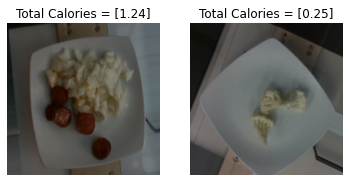

In [82]:
plt.figure(figsize=(6, 4))
for i in range(2):
  iterator = next(sample50_train_gen)
  image = iterator[0]
  tc = iterator[1]
  image = np.squeeze(image)
  plt.subplot(1,2,i+1)
  plt.imshow(image.astype('uint8'))
  plt.title("Total Calories = " + str(tc))
  plt.axis("off")

## Sample Batch Validation Images

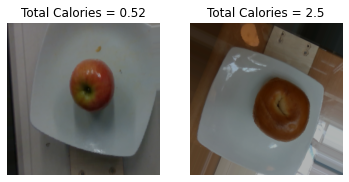

In [83]:
plt.figure(figsize=(6, 4))
for i in range(2):
  iterator = next(sample50_test_gen)
  image = iterator[0]
  tc = iterator[1]
  image = np.squeeze(image)
  plt.subplot(1,2,i+1)
  plt.imshow(image.astype('uint8'))
  label = round(tc[0] ,2)
  plt.title("Total Calories = " + str(label))
  plt.axis("off")

## Sample Patches (16 * 16)

Image size: 256 X 256
Patch size: 16 X 16
256 patches per image 
768 elements per patch


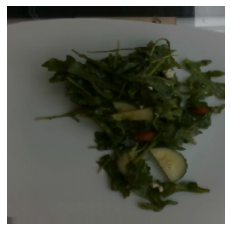

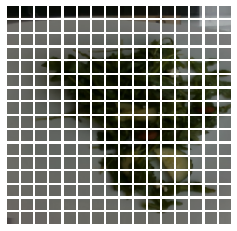

In [84]:
patch_size = 16  # Size of the patches to be extracted from the input images
image = next(sample50_train_gen)[0]
image = np.squeeze(image)
plt.figure(figsize=(4, 4))
plt.imshow(image.astype('uint8'))
plt.axis("off")

patches = Patches(vit_config_1)(tf.convert_to_tensor([image]))
print(f"Image size: {vit_config_1.image_size} X {vit_config_1.image_size}")
print(f"Patch size: {vit_config_1.patch_size} X {vit_config_1.patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Training Model - 1

### Callbacks

In [94]:
callbackHelper = CallbackHelper(workspace)
model_checkpoint = callbackHelper.create_callback(callback_name="MC",experiment="/model-1")
tensorboard_callback = callbackHelper.create_callback(callback_name="TB",experiment="/model-1")
early_stop_callback = callbackHelper.create_callback(callback_name="ES",es_patience=0)
tqdm_callback = callbackHelper.create_callback(callback_name="TQDM")
callback_list = [tqdm_callback,model_checkpoint,tensorboard_callback]

Log file used =  /home/ubuntu/logs/model-1/20221124-185054/MC
Log file used =  /home/ubuntu/logs/model-1/20221124-185054/TB


### Compile

In [95]:
callback_list

In [96]:
vm_lr_1 = 1e-4
vit_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=vm_lr_1),
              loss="mean_squared_error",
              metrics="mean_absolute_error")

### Fit Model

In [97]:
batch = 10
num_epochs = 20

hist_model_1 = vit_model_1.fit(
        sample50_train_gen,
        validation_data = sample50_test_gen,
        batch_size=batch,
        epochs=num_epochs,
        callbacks= callback_list
    )

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/36           ETA: ?s - 

Epoch 1/20
 4/36 [==>...........................] - ETA: 0s - loss: 0.7402 - mean_absolute_error: 0.7240  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0157s). Check your callbacks.


36/36 [==============================] - ETA: 0s - loss: 2.6076 - mean_absolute_error: 1.1449

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 20s 412ms/step - loss: 2.6076 - mean_absolute_error: 1.1449 - val_loss: 0.8423 - val_mean_absolute_error: 0.5900
Epoch 2/20


0/36           ETA: ?s - 

Epoch 2/20
33/36 [==========================>...] - ETA: 0s - loss: 2.6419 - mean_absolute_error: 1.3105

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 420ms/step - loss: 2.5318 - mean_absolute_error: 1.2839 - val_loss: 0.6863 - val_mean_absolute_error: 0.5217
Epoch 3/20


0/36           ETA: ?s - 

Epoch 3/20
33/36 [==========================>...] - ETA: 0s - loss: 1.7655 - mean_absolute_error: 0.9084

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 424ms/step - loss: 1.7759 - mean_absolute_error: 0.9413 - val_loss: 0.7885 - val_mean_absolute_error: 0.5543
Epoch 4/20


0/36           ETA: ?s - 

Epoch 4/20
34/36 [===========================>..] - ETA: 0s - loss: 3.6074 - mean_absolute_error: 1.4766

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 404ms/step - loss: 3.4351 - mean_absolute_error: 1.4331 - val_loss: 1.0659 - val_mean_absolute_error: 0.7636
Epoch 5/20


0/36           ETA: ?s - 

Epoch 5/20
33/36 [==========================>...] - ETA: 0s - loss: 1.5305 - mean_absolute_error: 0.8871

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 427ms/step - loss: 1.4327 - mean_absolute_error: 0.8564 - val_loss: 0.9279 - val_mean_absolute_error: 0.6585
Epoch 6/20


0/36           ETA: ?s - 

Epoch 6/20
35/36 [============================>.] - ETA: 0s - loss: 2.2299 - mean_absolute_error: 1.1000

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 405ms/step - loss: 2.1733 - mean_absolute_error: 1.0816 - val_loss: 0.9920 - val_mean_absolute_error: 0.7024
Epoch 7/20


0/36           ETA: ?s - 

Epoch 7/20
35/36 [============================>.] - ETA: 0s - loss: 2.8587 - mean_absolute_error: 1.1843

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 427ms/step - loss: 2.7856 - mean_absolute_error: 1.1647 - val_loss: 0.6875 - val_mean_absolute_error: 0.5180
Epoch 8/20


0/36           ETA: ?s - 

Epoch 8/20
36/36 [==============================] - ETA: 0s - loss: 1.8119 - mean_absolute_error: 1.0434

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 419ms/step - loss: 1.8119 - mean_absolute_error: 1.0434 - val_loss: 0.7787 - val_mean_absolute_error: 0.5657
Epoch 9/20


0/36           ETA: ?s - 

Epoch 9/20
35/36 [============================>.] - ETA: 0s - loss: 2.2136 - mean_absolute_error: 1.0697

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 406ms/step - loss: 2.2166 - mean_absolute_error: 1.0823 - val_loss: 0.9186 - val_mean_absolute_error: 0.6537
Epoch 10/20


0/36           ETA: ?s - 

Epoch 10/20
33/36 [==========================>...] - ETA: 0s - loss: 2.3016 - mean_absolute_error: 1.0378

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 428ms/step - loss: 2.1238 - mean_absolute_error: 0.9817 - val_loss: 1.0359 - val_mean_absolute_error: 0.7393
Epoch 11/20


0/36           ETA: ?s - 

Epoch 11/20
33/36 [==========================>...] - ETA: 0s - loss: 2.3848 - mean_absolute_error: 1.1186

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 402ms/step - loss: 2.3038 - mean_absolute_error: 1.1099 - val_loss: 1.0852 - val_mean_absolute_error: 0.7726
Epoch 12/20


0/36           ETA: ?s - 

Epoch 12/20
33/36 [==========================>...] - ETA: 0s - loss: 1.8964 - mean_absolute_error: 1.0256

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 424ms/step - loss: 1.8257 - mean_absolute_error: 1.0178 - val_loss: 1.6898 - val_mean_absolute_error: 1.0968
Epoch 13/20


0/36           ETA: ?s - 

Epoch 13/20
35/36 [============================>.] - ETA: 0s - loss: 1.7250 - mean_absolute_error: 0.9796

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 402ms/step - loss: 1.7023 - mean_absolute_error: 0.9789 - val_loss: 0.8181 - val_mean_absolute_error: 0.5823
Epoch 14/20


0/36           ETA: ?s - 

Epoch 14/20
33/36 [==========================>...] - ETA: 0s - loss: 1.4138 - mean_absolute_error: 0.8462

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 424ms/step - loss: 1.3276 - mean_absolute_error: 0.8110 - val_loss: 1.0168 - val_mean_absolute_error: 0.7136
Epoch 15/20


0/36           ETA: ?s - 

Epoch 15/20
35/36 [============================>.] - ETA: 0s - loss: 1.7278 - mean_absolute_error: 0.9583

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 423ms/step - loss: 1.6964 - mean_absolute_error: 0.9532 - val_loss: 0.8935 - val_mean_absolute_error: 0.6347
Epoch 16/20


0/36           ETA: ?s - 

Epoch 16/20
36/36 [==============================] - ETA: 0s - loss: 1.7312 - mean_absolute_error: 0.9214

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 403ms/step - loss: 1.7312 - mean_absolute_error: 0.9214 - val_loss: 0.6204 - val_mean_absolute_error: 0.5328
Epoch 17/20


0/36           ETA: ?s - 

Epoch 17/20
36/36 [==============================] - ETA: 0s - loss: 1.7125 - mean_absolute_error: 1.0208

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 427ms/step - loss: 1.7125 - mean_absolute_error: 1.0208 - val_loss: 0.6085 - val_mean_absolute_error: 0.5287
Epoch 18/20


0/36           ETA: ?s - 

Epoch 18/20
36/36 [==============================] - ETA: 0s - loss: 2.4142 - mean_absolute_error: 1.0678

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 14s 403ms/step - loss: 2.4142 - mean_absolute_error: 1.0678 - val_loss: 0.9991 - val_mean_absolute_error: 0.7082
Epoch 19/20


0/36           ETA: ?s - 

Epoch 19/20
33/36 [==========================>...] - ETA: 0s - loss: 2.6013 - mean_absolute_error: 1.1574

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 425ms/step - loss: 2.4107 - mean_absolute_error: 1.1028 - val_loss: 0.6824 - val_mean_absolute_error: 0.5270
Epoch 20/20


0/36           ETA: ?s - 

Epoch 20/20
33/36 [==========================>...] - ETA: 0s - loss: 1.7069 - mean_absolute_error: 0.8981

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-185054/MC/assets


36/36 [==============================] - 15s 425ms/step - loss: 1.6125 - mean_absolute_error: 0.8825 - val_loss: 1.1308 - val_mean_absolute_error: 0.7894


In [ ]:
print(STOP HERE)

## Tensorboard

### Upload to tensorboard

In [98]:
%load_ext tensorboard

In [99]:
%tensorboard --logdir '/home/ubuntu/logs/model-1/20221124-185054/TB/' 

In [100]:
!tensorboard dev upload --logdir '/home/ubuntu/logs/model-1/20221124-185054/TB/'  --name "Prototype - 50" --description "Training on 50 sample dish images" 

^C


In [102]:
hist_model_1

### Plot Function

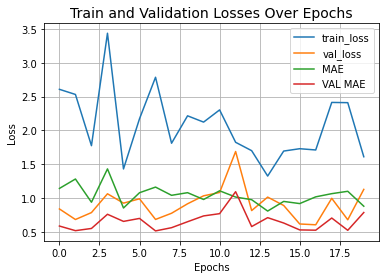

In [103]:
plt.plot(hist_model_1.history["loss"], label="train_loss")
plt.plot(hist_model_1.history["val_loss"], label="val_loss")
plt.plot(hist_model_1.history["mean_absolute_error"], label="MAE")
plt.plot(hist_model_1.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
batch = 10
num_epochs = 20

hist_model_1 = vit_model_1.fit(
        sample50_train_gen,
        validation_data = sample50_test_gen,
        batch_size=batch,
        epochs=num_epochs,
        callbacks= callback_list
    )

## Training Model - 1 with 100 records

### Sample 100 Images for Prototype

### Train/Test Split

In [111]:
SAMPLE_SIZE = 100
sample100_data = dish_info.sample(n=SAMPLE_SIZE)
print(sample100_data.shape)

(100, 7)


In [112]:
sample100_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
251,dish_1563996279,98.490021,278.0,1.893741,19.736820,3.910173,/home/ubuntu/dataset/processed_overhead/dish_1...
2612,dish_1562686664,119.129997,209.0,0.627000,29.260000,1.463000,/home/ubuntu/dataset/processed_overhead/dish_1...
3190,dish_1566849895,112.309998,153.0,7.341000,12.821001,1.310000,/home/ubuntu/dataset/processed_overhead/dish_1...
362,dish_1562788010,67.643532,182.0,1.845235,11.571823,2.979530,/home/ubuntu/dataset/processed_overhead/dish_1...
1088,dish_1562960472,139.970001,166.0,6.729000,16.591000,4.553000,/home/ubuntu/dataset/processed_overhead/dish_1...


In [74]:
# cropped_image_path = workspace + '/processed_overhead/'
# sample50_data.dish_id.apply(lambda x :  cropped_image_path + x + '/cropped.png')

'/home/ubuntu/processed_overhead/dish_1562963484/cropped.png'

In [113]:
fractions = np.array([0.8, 0.1, 0.1])
# shuffle
df = sample100_data.sample(frac=1) 
# split into 3 parts
train_100, val_100, test_100 = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(train_100.shape)
print(val_100.shape)
print(test_100.shape)
sample100_data = pd.concat([train_100,val_100])
sample100_data.shape

(80, 7)
(10, 7)
(10, 7)


(90, 7)

### Normalize total_calories
* Divide it by total_mass of the dish 

In [114]:
sample100_data["total_calories_norm"] = round(sample100_data["total_calories"]/sample100_data["total_mass"],2)

In [115]:
sample100_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 3220 to 2469
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              90 non-null     object 
 1   total_calories       90 non-null     float32
 2   total_mass           90 non-null     float32
 3   total_fat            90 non-null     float32
 4   total_carb           90 non-null     float32
 5   total_protein        90 non-null     float32
 6   image_path           90 non-null     object 
 7   total_calories_norm  90 non-null     float32
dtypes: float32(6), object(2)
memory usage: 4.2+ KB


### Data Generator

In [116]:
sample100_train_gen  = generator.flow_from_dataframe(dataframe=sample100_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              y_col = "total_calories_norm",
                              batch_size=1,
                              shuffle=True,
                              subset="training",
                              seed=123,
                              rescale=1.0/255)
sample100_test_gen  = generator.flow_from_dataframe(dataframe=sample100_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              batch_size=1,
                              seed=123,
                              y_col = "total_calories_norm",
                              subset="validation",
                              rescale=1.0/255)

Found 72 validated image filenames.
Found 18 validated image filenames.


### Callbacks

In [117]:
callbackHelper1 = CallbackHelper(workspace)
model_checkpoint1 = callbackHelper.create_callback(callback_name="MC",experiment="/model-1_100")
tensorboard_callback1 = callbackHelper.create_callback(callback_name="TB",experiment="/model-1_100")
early_stop_callback1 = callbackHelper.create_callback(callback_name="ES",es_patience=0)
tqdm_callback1 = callbackHelper.create_callback(callback_name="TQDM")
callback_list1 = [tqdm_callback1,model_checkpoint1,tensorboard_callback1]

Log file used =  /home/ubuntu/logs/model-1_100/20221124-185054/MC
Log file used =  /home/ubuntu/logs/model-1_100/20221124-185054/TB


In [118]:
callback_list1

### Compile

In [119]:
vm_lr_1 = 1e-4
vit_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=vm_lr_1),
              loss="mean_squared_error",
              metrics="mean_absolute_error")

### Fit Model

batch1 = 10
num_epochs1 = 20

model_1_hist1 = vit_model_1.fit(
        sample100_train_gen,
        validation_data = sample100_test_gen,
        batch_size=batch1,
        epochs=num_epochs1,
        callbacks= callback_list1
    )

In [ ]:
### Plots

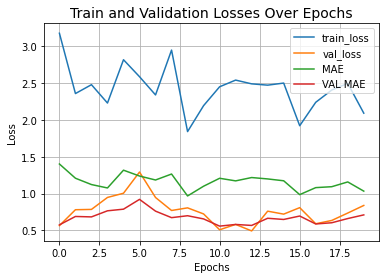

In [121]:
plt.plot(model_1_hist1.history["loss"], label="train_loss")
plt.plot(model_1_hist1.history["val_loss"], label="val_loss")
plt.plot(model_1_hist1.history["mean_absolute_error"], label="MAE")
plt.plot(model_1_hist1.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()